<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a3_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_pickle(zipfile, fn):
    return pickle.load(io.BytesIO(zipfile[fn]))

In [3]:
data = load_zip('https://surfdrive.surf.nl/files/index.php/s/cwqGaS22KXgnXtg/download')

    
"""
simulation_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_train = load_pickle(data, 'data/train/simulation.pickle')  # 3.1 + 3.2
simulation_valid = load_pickle(data, 'data/valid/simulation.pickle')  # 3.1 + 3.2
simulation_test = load_pickle(data, 'data/test/simulation.pickle')  # 3.1 + 3.2

"""
charges_{train, valid, test} is stored as a list of simulation-charges. 
These charges are stored as numpy arrays of size (3,): One value for each charge.
"""
charges_train = load_pickle(data, 'data/train/charges.pickle')  # 3.1
charges_valid = load_pickle(data, 'data/valid/charges.pickle')  # 3.1
charges_test = load_pickle(data, 'data/test/charges.pickle')  # 3.1

"""
simulation_continued_{train, valid, test} is stored as a list of simulations. 
Each simulation is a numpy array of size (t, 2): For t timesteps an x and y coordinate of our particle.
"""
simulation_continued_train = load_pickle(data, 'data/train/simulation_continued.pickle')  # 3.2
simulation_continued_valid = load_pickle(data, 'data/valid/simulation_continued.pickle')  # 3.2
simulation_continued_test = load_pickle(data, 'data/test/simulation_continued.pickle')  # 3.2

"""
Note that the indices are shared throughout the different lists, e.g., for the 4th training simulation:
simulation_train[3] contains its initial simulation
charges_train[3] contains the charges associated with the simulation
simulation_continued_train[3] contains the continuation of the simulation 
                --> simulation_continued_train[3][0] is the state after simulation_train[3][-1]
"""
pass

In [4]:
print('Overview of no. datapoints:\n')

print('Task 3.1:')
print(f'{len(simulation_train)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(charges_train)} train, {len(charges_valid)} validation, {len(charges_test)} test charge pairs')
print()

print('Task 3.2:')
print('Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations')
print('We cut simulation_train down to the first 150 samples in simulation_train_task32')
simulation_train_task32 = simulation_train[:150]
print(f'{len(simulation_train_task32)} train, {len(simulation_valid)} validation, {len(simulation_test)} test simulations')
print(f'{len(simulation_continued_train)} train, {len(simulation_continued_valid)} validation, {len(simulation_continued_test)} test continuations')

print(f"""
For task 3.1, use:
{chr(10).join(["simulation_{} + charges_{}".format(t, t) for t in ["train", "valid", "test"]])}

For task 3.2, use:
{chr(10).join(["simulation_{} + simulation_continued_{}".format(*((t[0], t[1]) if isinstance(t, tuple) else (t, t))) for t in [("train_task32", "train"), "valid", "test"]])}
""")


Overview of no. datapoints:

Task 3.1:
800 train, 100 validation, 100 test simulations
800 train, 100 validation, 100 test charge pairs

Task 3.2:
Since len(simulation_continued_train) < len(simulation_train), we can only use a subset of initial simulations
We cut simulation_train down to the first 150 samples in simulation_train_task32
150 train, 100 validation, 100 test simulations
150 train, 100 validation, 100 test continuations

For task 3.1, use:
simulation_train + charges_train
simulation_valid + charges_valid
simulation_test + charges_test

For task 3.2, use:
simulation_train_task32 + simulation_continued_train
simulation_valid + simulation_continued_valid
simulation_test + simulation_continued_test



In [5]:
print('Print some shapes:\n')
for i in range(3):
    print('simulation_train[{}].shape:'.format(i), simulation_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('charges_train[{}].shape:'.format(i), charges_train[i].shape, '-> charges for the simulation')
    print('simulation_continued_train[{}].shape:'.format(i), simulation_continued_train[i].shape, '-> (t, 2), (x, y) at every t)')
    print('----\n')

Print some shapes:

simulation_train[0].shape: (103, 2) -> (t, 2), (x, y) at every t)
charges_train[0].shape: (3,) -> charges for the simulation
simulation_continued_train[0].shape: (54, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[1].shape: (97, 2) -> (t, 2), (x, y) at every t)
charges_train[1].shape: (3,) -> charges for the simulation
simulation_continued_train[1].shape: (45, 2) -> (t, 2), (x, y) at every t)
----

simulation_train[2].shape: (99, 2) -> (t, 2), (x, y) at every t)
charges_train[2].shape: (3,) -> charges for the simulation
simulation_continued_train[2].shape: (47, 2) -> (t, 2), (x, y) at every t)
----



In [6]:
def plot_example(x, x_gt=None, x_pred=None, fn=None):
    charge_locations = np.array([[-1.53846154, -1.53846154],
                                 [ 1.53846154, -1.53846154],
                                 [ 0.        ,  1.53846154]])  # charge locations are fixed
    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    cmap = matplotlib.cm.get_cmap('tab20')
    plt.plot(x[:, 0], x[:, 1], color=cmap(0))
    plt.plot(x[0, 0], x[0, 1], 'd', color=cmap(1))
    fig.set_size_inches(5, 5)
    for charge in charge_locations:
        plt.plot(charge[0], charge[1], 'd', color='black')
    if x_gt is not None:
        plt.plot(x_gt[:, 0], x_gt[:, 1], color='red', linewidth=.5)
    if x_pred is not None:
        plt.plot(x_pred[:, 0], x_pred[:, 1], color='green', linestyle='--')
    if fn is None:
        plt.show()
    else:
        plt.savefig(fn)

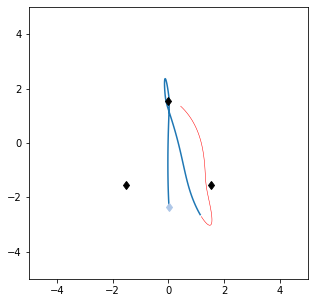

Charges are [-0.44862364 -0.51910605 -0.40360995]


In [7]:
test_idx = np.random.randint(150)
plot_example(simulation_train[test_idx], simulation_continued_train[test_idx])
print(f'Charges are {charges_train[test_idx]}')

# Task 3.1

## Data Handling and Preprocessing

In [8]:
#todo
#Playground
device = 'cuda:0'

In [9]:
#Task 3.1
from torch.utils.data import Dataset, DataLoader,TensorDataset
class DatasetTaskOne(Dataset):
    def __init__(self, simulation_data,charge_targets):
        padded_len = len(max(simulation_data, key=len)) # Should be 110 ideally but set to max length just in case
        padded_arrays = []
        for i in range(len(simulation_data)):
            diff = padded_len - simulation_data[i].shape[0] # How many rows should we pad?
            # Pad diff amount of [0,0] rows to the end 
            padded_arrays.append(np.pad(simulation_data[i],[(0,diff),(0,0)],mode='constant',constant_values=0))
        # Create data and target tensors
        data = np.array(padded_arrays)
        (samples,length,pos_dim) = data.shape
        self.data = torch.FloatTensor(data).view(samples,1,-1) # Samples,Channels,Sequence length
        print(self.data.shape)
        self.targets = torch.FloatTensor(np.array(charge_targets))
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [10]:
diff = len(max(simulation_train, key = len)) - simulation_train[0].shape[0]

In [11]:
#Task 3.2

from torch.utils.data import Dataset, DataLoader,TensorDataset
class DatasetTaskTwo(Dataset):
    def __init__(self, simulation_data,continued_simulations):
        padded_len = len(max(simulation_data, key=len)) # Should be 110 ideally but set to max length just in case
        padded_arrays = []
        for i in range(len(simulation_data)):
            diff = padded_len - simulation_data[i].shape[0] # How many rows should we pad?
            # Pad diff amount of [0,0] rows to the end 
            padded_arrays.append(np.pad(simulation_data[i],[(0,diff),(0,0)],mode='constant',constant_values=0))
        # Create data and target tensors
        data = np.array(padded_arrays)
        (samples,length,pos_dim) = data.shape
        self.data = torch.FloatTensor(data).view(samples,1,-1) # Samples,Channels,Sequence length
        print(len(self.data))
        print(self.data.shape)
        
        
        padded_len_target = len(max(continued_simulations, key = len))
        padded_target_array = []
        for j in range(len(continued_simulations)):
            diff_targ = padded_len_target - continued_simulations[j].shape[0]
            padded_target_array.append(np.pad(continued_simulations[j], [(0, diff_targ), (0,0)], mode = 'constant', constant_values = 0))
        targets = np.array(padded_target_array)
        
        (targ_samples, targ_length, targ_pos_dim) = targets.shape
        self.targets = torch.FloatTensor(targets).view(targ_samples,1,-1)
        print(len(self.targets))
        print(self.targets.shape)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [12]:
#For task 3.1
t1_train_dataset = DatasetTaskOne(simulation_train,charges_train)
t1_train_loader = torch.utils.data.DataLoader(t1_train_dataset, batch_size=10)
t1_valid_dataset = DatasetTaskOne(simulation_valid,charges_valid)
t1_valid_loader = torch.utils.data.DataLoader(t1_valid_dataset, batch_size=10)
t1_test_dataset = DatasetTaskOne(simulation_test,charges_test)
t1_test_loader = torch.utils.data.DataLoader(t1_test_dataset, batch_size=10)

torch.Size([800, 1, 220])
torch.Size([100, 1, 220])
torch.Size([100, 1, 220])


In [13]:
#For task 3.2
t2_train_dataset = DatasetTaskTwo(simulation_train_task32,simulation_continued_train)
t2_train_loader = torch.utils.data.DataLoader(t2_train_dataset, batch_size=10)
t2_valid_dataset = DatasetTaskTwo(simulation_valid,simulation_continued_valid)
t2_valid_loader = torch.utils.data.DataLoader(t2_valid_dataset, batch_size=10)
t2_test_dataset = DatasetTaskTwo(simulation_test,simulation_continued_test)
t2_test_loader = torch.utils.data.DataLoader(t2_test_dataset, batch_size=10)

150
torch.Size([150, 1, 220])
150
torch.Size([150, 1, 120])
100
torch.Size([100, 1, 220])
100
torch.Size([100, 1, 120])
100
torch.Size([100, 1, 220])
100
torch.Size([100, 1, 118])


In [14]:
#testing the train loader
a, b = [], []
for train, targ in t2_train_loader:
    a.append(train)
    b.append(targ)

In [15]:
a[0][0].shape

torch.Size([1, 220])

In [16]:
b[0][0].shape

torch.Size([1, 120])

## Model Implementation

In [17]:
#todo
from torch import nn

In [18]:
##Task 3.1

In [19]:
class GRURegressor(nn.Module):

    def __init__(self, input_dim,hidden_dim,output_dim,device):
        super(GRURegressor, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.device = device
        
        # Compress sequence length into filters 
        self.rnn = nn.GRUCell(input_dim, hidden_dim)
        
        #self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, batch_input ):
        
        # input shapes:
        # batch_input: [batch_size, 1,seq_length]
            
        # Generate initial hidden and cell states
        hidden = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device) 
        
        # Feed packed input sequence to lstm 
        for i in range(0,220,2):
            hidden = self.rnn(batch_input[:,0,i:i+2],hidden) # Pass the i-th compressed sequence step
        # feed output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h = nn.ReLU()(self.fc1(hidden))
        output = self.fc2(h)
        return output

In [20]:
class ConvGRURegressor(nn.Module):

    def __init__(self, input_dim,hidden_dim,output_dim,device, conv_filters=64,kernel_size=4,stride=4):
        super(ConvGRURegressor, self).__init__()
        
        self.input_dim = input_dim
        self.conv_filters = conv_filters
        self.hidden_dim = hidden_dim
        self.device = device
        
        # Compress sequence length into filters 
        self.conv1d_1 = nn.Conv1d(1,out_channels=conv_filters,kernel_size=kernel_size,stride=stride,padding="valid")
        self.conv1d_2 = nn.Conv1d(conv_filters,out_channels=conv_filters*2,kernel_size=kernel_size,stride=stride,padding="valid")
        self.rnn = nn.GRUCell(conv_filters*2, hidden_dim)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, batch_input ):
        
        # input shapes:
        # batch_input: [batch_size, 1,seq_length]
        embedding = self.conv1d_1(batch_input) # embedding: [batch_size,filters,reduced_sequence_length]
        embedding2 = self.conv1d_2(embedding) # embedding: [batch_size,filters,reduced_sequence_length]
            
        # Generate initial hidden and cell states
        hidden = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device) 
        
        # Feed packed input sequence to lstm 
        for i in range(embedding2.shape[2]):
            hidden = self.rnn(embedding2[:,:,i],hidden) # Pass the i-th compressed sequence step
        #hidden = self.drop(hidden)
        # feed output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h = nn.ReLU()(self.fc1(hidden))
        output = self.fc2(h)
        return output

In [21]:
class BenchmarkFNN(nn.Module):

    def __init__(self, input_dim,hidden_dim,output_dim,device):
        super(BenchmarkFNN, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.device = device
        
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc3 = nn.Linear(hidden_dim//2, output_dim)
    
    def forward(self, batch_input):
        
        # feed output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h1 = nn.ReLU()(self.fc1(batch_input))
        h1 = self.drop(h1)
        h2 = nn.ReLU()(self.fc2(h1))
        output = self.fc3(h2)
        return output

In [22]:
#Task 3.2

In [23]:
#GRU with attention
#we need our model to have input dim = 2 and output_dim = 120 (we need a sequence in the output) 

class GRURegressor32(nn.Module):

    def __init__(self, input_dim,hidden_dim,output_dim,device):
        super(GRURegressor32, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.device = device
        
        # Compress sequence length into filters 
        self.rnn1 = nn.GRUCell(input_dim, hidden_dim)
        self.rnn2 = nn.GRUCell(hidden_dim, hidden_dim)
        #self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, batch_input ):
        
        # input shapes:
        # batch_input: [batch_size, 1,seq_length]
            
        # Generate initial hidden and cell states
        hidden = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device) 
        
        # Feed packed input sequence to lstm 
        for i in range(0,220,2):
            hidden = self.rnn1(batch_input[:,0,i:i+2],hidden) # Pass the i-th compressed sequence step
        # feed output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        #hidden_dim = [10, 256]
        
        
        #so i have my hidden vector at time = t
        hidden_vectors = []
        output_vectors = []
        
        hidden2 = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device)
        for j in range(0,60):
            hidden2 = self.rnn2(hidden, hidden2)
            hidden_vectors.append(hidden2)
            #each vector has shape [10, 256]
            #batch =1 so the shape is [1,256]
        
        
        for op in range(len(hidden_vectors)):
            h1 = nn.ReLU()(self.fc1(hidden_vectors[op]))
            h2 = self.fc2(h1) #operation [10,256] and [256,2]
            #h2 has a dimension (10, 2)
            #h2 batch =1 has the shape (1,2) and we have 60 time steps.
            

            output_vectors.append(h2)
            
        outputs = torch.stack(output_vectors, dim=1)
        
        final_output = []
        for tens in range(len(outputs)):
            t = outputs[tens].view(1,-1) #we need the output as [10,1,120], it was [10,60,20]. Hence the conversion
            final_output.append(t)
        
        model_output = torch.stack(final_output)
            
        return model_output

In [35]:

class ConvGRURegressor32(nn.Module):

    def __init__(self, input_dim,hidden_dim,output_dim,device, conv_filters=64,kernel_size=4,stride=4):
        super(ConvGRURegressor32, self).__init__()
        
        self.input_dim = input_dim
        self.conv_filters = conv_filters
        self.hidden_dim = hidden_dim
        self.device = device
        
        # Compress sequence length into filters 
        self.conv1d_1 = nn.Conv1d(1,out_channels=conv_filters,kernel_size=kernel_size,stride=stride,padding="valid")
        self.conv1d_2 = nn.Conv1d(conv_filters,out_channels=conv_filters*2,kernel_size=kernel_size,stride=stride,padding="valid")
        self.rnn1 = nn.GRUCell(conv_filters*2, hidden_dim)
        self.rnn2 = nn.GRUCell(hidden_dim, hidden_dim)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, batch_input ):
        
        # input shapes:
        # batch_input: [batch_size, 1,seq_length]
        embedding = self.conv1d_1(batch_input) # embedding: [batch_size,filters,reduced_sequence_length]
        embedding2 = self.conv1d_2(embedding) # embedding: [batch_size,filters,reduced_sequence_length]
            
        # Generate initial hidden and cell states
        hidden = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device) 
        
        # Feed packed input sequence to lstm 
        for i in range(embedding2.shape[2]):
            hidden = self.rnn1(embedding2[:,:,i],hidden) # Pass the i-th compressed sequence step
        #hidden = self.drop(hidden)
        # feed output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
    
        #so i have my hidden vector at time = t
        hidden_vectors = []
        output_vectors = []
        
        hidden2 = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device)
        for j in range(0,60):
            hidden2 = self.rnn2(hidden, hidden2)
            hidden_vectors.append(hidden2)
            #each vector has shape [10, 256]
            #batch =1 so the shape is [1,256]
        
        
        for op in range(len(hidden_vectors)):
            h1 = nn.ReLU()(self.fc1(hidden_vectors[op]))
            h2 = self.fc2(h1) #operation [10,256] and [256,2]
            #h2 has a dimension (10, 2)
            #h2 batch =1 has the shape (1,2) and we have 60 time steps.
            

            output_vectors.append(h2)
            
        outputs = torch.stack(output_vectors, dim=1)
        
        final_output = []
        for tens in range(len(outputs)):
            t = outputs[tens].view(1,-1) #we need the output as [10,1,120], it was [10,60,20]. Hence the conversion
            final_output.append(t)
        
        model_output = torch.stack(final_output)
            
        return model_output

In [36]:
model = ConvGRURegressor32(input_dim=220,hidden_dim=256,output_dim = 2, device = 'cpu')
criterion = nn.MSELoss()
for train_data, targets in t2_train_loader:
    # Forward
    input_tensor = train_data
    outputs = model.forward(input_tensor)
    loss = criterion(outputs,targ)

In [37]:
train_data.shape

torch.Size([10, 1, 220])

In [38]:
targets.shape

torch.Size([10, 1, 120])

In [39]:
outputs.shape

torch.Size([10, 1, 120])

In [40]:
loss

tensor(1.9955, grad_fn=<MseLossBackward0>)

## Model Training

In [27]:
#todo
def save_model_checkpoint(path, model, optimizer, val_loss, val_acc, train_acc, train_loss ):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "val_loss_dict": val_loss,
                 "val_acc_dict": val_acc,
                 "train_acc_dict": train_acc,
                 "train_loss_dict": train_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))

In [24]:
# training and validation after every epoch
def train(model, train_loader, val_loader, criterion, num_epochs, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    train_pred = []
    val_pred = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_train_acc = 0.0
  
        model.train()
        print("Starting epoch " + str(epoch+1))
        for train_data, targets in train_loader:
            
           
            # Forward
            input_tensor = train_data.to(device)
            outputs = model.forward(input_tensor)
            loss = criterion(outputs,targets.to(device))
            loss = loss/120
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            running_loss += loss
          

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print("Train Pass Completed")

        ########################################|Validation Set|#############################################
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for val_data, val_targets in val_loader:
                input_tensor = val_data.to(device)
                outputs = model.forward(input_tensor)
                loss = criterion(outputs,val_targets.to(device))
                val_running_loss += loss

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}' 
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss 
            save_model_checkpoint(save_name, model, optimizer, best_val_loss, 0, 0, avg_train_loss )
    
    print("Finished Training") 
    return train_losses, val_losses
     

In [ ]:
GRU_reg = GRURegressor(input_dim=2,hidden_dim=256,output_dim=3,device='cuda:0').cuda()

optimizer = torch.optim.SGD(GRU_reg.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(GRU_reg.parameters(), lr= 1e-4, weight_decay = 0.01)
num_epochs = 300
save_name = f'GRU_reg.pt'
criterion = nn.MSELoss()

obtained_train_loss, obtained_val_loss = train(GRU_reg, 
                                                      t1_train_loader, t1_valid_loader, criterion, num_epochs, save_name)

Starting epoch 1
Train Pass Completed
Epoch [1/300],Train Loss: 0.1161, Valid Loss: 0.09134934
Model Saved to ==> GRU_reg.pt
Starting epoch 2
Train Pass Completed
Epoch [2/300],Train Loss: 0.0828, Valid Loss: 0.09106201
Model Saved to ==> GRU_reg.pt
Starting epoch 3
Train Pass Completed
Epoch [3/300],Train Loss: 0.0825, Valid Loss: 0.09090095
Model Saved to ==> GRU_reg.pt
Starting epoch 4
Train Pass Completed
Epoch [4/300],Train Loss: 0.0823, Valid Loss: 0.09077165
Model Saved to ==> GRU_reg.pt
Starting epoch 5
Train Pass Completed
Epoch [5/300],Train Loss: 0.0822, Valid Loss: 0.09065922
Model Saved to ==> GRU_reg.pt
Starting epoch 6
Train Pass Completed
Epoch [6/300],Train Loss: 0.0821, Valid Loss: 0.09056215
Model Saved to ==> GRU_reg.pt
Starting epoch 7
Train Pass Completed
Epoch [7/300],Train Loss: 0.0820, Valid Loss: 0.09046462
Model Saved to ==> GRU_reg.pt
Starting epoch 8
Train Pass Completed
Epoch [8/300],Train Loss: 0.0820, Valid Loss: 0.09037244
Model Saved to ==> GRU_reg.pt


In [225]:
conv_GRU_reg = ConvGRURegressor(input_dim=220,hidden_dim=256,output_dim=3,device='cuda:0').cuda()

#optimizer = torch.optim.SGD(GRU_reg.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(conv_GRU_reg.parameters(), lr= 6e-4, weight_decay = 0.01)
num_epochs = 100
save_name = f'conv_GRU_reg.pt'
criterion = nn.MSELoss()

obtained_train_loss, obtained_val_loss = train(conv_GRU_reg, 
                                                      t1_train_loader, t1_valid_loader, criterion, num_epochs, save_name)

Starting epoch 1
Train Pass Completed
Epoch [1/100],Train Loss: 0.0844, Valid Loss: 0.07058328
Model Saved to ==> conv_GRU_reg.pt
Starting epoch 2
Train Pass Completed
Epoch [2/100],Train Loss: 0.0623, Valid Loss: 0.06625268
Model Saved to ==> conv_GRU_reg.pt
Starting epoch 3
Train Pass Completed
Epoch [3/100],Train Loss: 0.0603, Valid Loss: 0.06607549
Model Saved to ==> conv_GRU_reg.pt
Starting epoch 4
Train Pass Completed
Epoch [4/100],Train Loss: 0.0593, Valid Loss: 0.06633176
Starting epoch 5
Train Pass Completed
Epoch [5/100],Train Loss: 0.0591, Valid Loss: 0.06721675
Starting epoch 6
Train Pass Completed
Epoch [6/100],Train Loss: 0.0591, Valid Loss: 0.06836617
Starting epoch 7
Train Pass Completed
Epoch [7/100],Train Loss: 0.0595, Valid Loss: 0.06923538
Starting epoch 8
Train Pass Completed
Epoch [8/100],Train Loss: 0.0598, Valid Loss: 0.06914496
Starting epoch 9
Train Pass Completed
Epoch [9/100],Train Loss: 0.0600, Valid Loss: 0.06812099
Starting epoch 10
Train Pass Completed
E

Train Pass Completed
Epoch [78/100],Train Loss: 0.0568, Valid Loss: 0.06482341
Starting epoch 79
Train Pass Completed
Epoch [79/100],Train Loss: 0.0568, Valid Loss: 0.06472896
Starting epoch 80
Train Pass Completed
Epoch [80/100],Train Loss: 0.0568, Valid Loss: 0.06486375
Starting epoch 81
Train Pass Completed
Epoch [81/100],Train Loss: 0.0568, Valid Loss: 0.06496435
Starting epoch 82
Train Pass Completed
Epoch [82/100],Train Loss: 0.0567, Valid Loss: 0.06485518
Starting epoch 83
Train Pass Completed
Epoch [83/100],Train Loss: 0.0568, Valid Loss: 0.06480227
Starting epoch 84
Train Pass Completed
Epoch [84/100],Train Loss: 0.0568, Valid Loss: 0.06466407
Model Saved to ==> conv_GRU_reg.pt
Starting epoch 85
Train Pass Completed
Epoch [85/100],Train Loss: 0.0567, Valid Loss: 0.06477292
Starting epoch 86
Train Pass Completed
Epoch [86/100],Train Loss: 0.0567, Valid Loss: 0.06461605
Model Saved to ==> conv_GRU_reg.pt
Starting epoch 87
Train Pass Completed
Epoch [87/100],Train Loss: 0.0568, V

In [201]:
# Benchmark Neural Network. Play around with hidden dim.
benchmark_fnn = BenchmarkFNN(input_dim=220,hidden_dim=256,output_dim=3,device='cuda:0').cuda()

#optimizer = torch.optim.SGD(GRU_reg.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(benchmark_fnn.parameters(), lr= 6e-4, weight_decay = 0.01)
num_epochs = 100
save_name = f'benchmark_fnn.pt'
criterion = nn.MSELoss()

obtained_train_loss, obtained_val_loss = train(benchmark_fnn, 
                                                      t1_train_loader, t1_valid_loader, criterion, num_epochs, save_name)

Starting epoch 1
Train Pass Completed
Epoch [1/100],Train Loss: 0.1255, Valid Loss: 0.11048593
Model Saved to ==> benchmark_fnn.pt
Starting epoch 2
Train Pass Completed
Epoch [2/100],Train Loss: 0.0985, Valid Loss: 0.09961852
Model Saved to ==> benchmark_fnn.pt
Starting epoch 3
Train Pass Completed
Epoch [3/100],Train Loss: 0.0944, Valid Loss: 0.09823599
Model Saved to ==> benchmark_fnn.pt
Starting epoch 4
Train Pass Completed
Epoch [4/100],Train Loss: 0.0923, Valid Loss: 0.09767643
Model Saved to ==> benchmark_fnn.pt
Starting epoch 5
Train Pass Completed
Epoch [5/100],Train Loss: 0.0923, Valid Loss: 0.09530633
Model Saved to ==> benchmark_fnn.pt
Starting epoch 6
Train Pass Completed
Epoch [6/100],Train Loss: 0.0908, Valid Loss: 0.09753335
Starting epoch 7
Train Pass Completed
Epoch [7/100],Train Loss: 0.0907, Valid Loss: 0.09764654
Starting epoch 8
Train Pass Completed
Epoch [8/100],Train Loss: 0.0902, Valid Loss: 0.09651460
Starting epoch 9
Train Pass Completed
Epoch [9/100],Train Lo

Train Pass Completed
Epoch [79/100],Train Loss: 0.0832, Valid Loss: 0.09152376
Starting epoch 80
Train Pass Completed
Epoch [80/100],Train Loss: 0.0831, Valid Loss: 0.09177291
Starting epoch 81
Train Pass Completed
Epoch [81/100],Train Loss: 0.0831, Valid Loss: 0.09197382
Starting epoch 82
Train Pass Completed
Epoch [82/100],Train Loss: 0.0830, Valid Loss: 0.09154239
Starting epoch 83
Train Pass Completed
Epoch [83/100],Train Loss: 0.0829, Valid Loss: 0.09129942
Model Saved to ==> benchmark_fnn.pt
Starting epoch 84
Train Pass Completed
Epoch [84/100],Train Loss: 0.0831, Valid Loss: 0.09150403
Starting epoch 85
Train Pass Completed
Epoch [85/100],Train Loss: 0.0831, Valid Loss: 0.09168002
Starting epoch 86
Train Pass Completed
Epoch [86/100],Train Loss: 0.0830, Valid Loss: 0.09131439
Starting epoch 87
Train Pass Completed
Epoch [87/100],Train Loss: 0.0829, Valid Loss: 0.09158293
Starting epoch 88
Train Pass Completed
Epoch [88/100],Train Loss: 0.0830, Valid Loss: 0.09157836
Starting epo

In [28]:
#Task 3.2

device = 'cpu'
GRU_reg = GRURegressor32(input_dim=2,hidden_dim=256,output_dim=2,device='cpu')

optimizer = torch.optim.SGD(GRU_reg.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(GRU_reg.parameters(), lr= 1e-4, weight_decay = 0.01)
num_epochs = 2
save_name = f'GRU_reg_seq_32.pt'
criterion = nn.MSELoss()

obtained_train_loss, obtained_val_loss = train(GRU_reg, 
                                                      t2_train_loader, 
                                                      t2_valid_loader, criterion, num_epochs, save_name)





Starting epoch 1
Train Pass Completed
Epoch [1/2],Train Loss: 2.0450, Valid Loss: 2.19615507
Model Saved to ==> GRU_reg_seq_32.pt
Starting epoch 2
Train Pass Completed
Epoch [2/2],Train Loss: 2.0311, Valid Loss: 2.19309521
Model Saved to ==> GRU_reg_seq_32.pt
Finished Training


## Evaluation

In [37]:
targets.size()

torch.Size([120, 1])

In [39]:
outputs.size()

torch.Size([120, 1])

In [38]:
input_tensor.size()

torch.Size([1, 1, 220])

# Task 3.2

## Data Handling and Preprocessing

In [ ]:
#todo

## Model Implementation

In [ ]:
#todo

## Model Training

In [ ]:
#todo

## Evaluation

In [ ]:
#todo